In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

results_df = pd.read_csv('../data/driver-results-monza.csv',)

results_df

,number,driver,constructor,position,grid,year
0,3,michael_schumacher,ferrari,1,1,2000
1,1,hakkinen,mclaren,2,3,2000
2,9,ralf_schumacher,williams,3,7,2000
3,19,verstappen,arrows,4,11,2000
4,12,wurz,benetton,5,13,2000
...,...,...,...,...,...,...
521,77,bottas,sauber,16,19,2024
522,27,hulkenberg,haas,17,10,2024
523,24,zhou,sauber,18,20,2024
524,18,stroll,aston_martin,19,17,2024


In [39]:
results_df[results_df['driver'] == 'hamilton']

,number,driver,constructor,position,grid,year
147,2,hamilton,mclaren,2,2,2007
174,22,hamilton,mclaren,7,15,2008
199,1,hamilton,mclaren,12,1,2009
230,2,hamilton,mclaren,23,5,2010
235,3,hamilton,mclaren,4,2,2011
256,4,hamilton,mclaren,1,1,2012
288,10,hamilton,mercedes,9,12,2013
302,44,hamilton,mercedes,1,1,2014
324,44,hamilton,mercedes,1,1,2015
345,44,hamilton,mercedes,2,1,2016


# Starting Probability

Starting probability is expressed as follows: what is the likelihood of a given grid position to win the race. To caluclate this we will use the historical data dating back as far as we have data for. We then take all the winners (classified as position 1) and use an exponential function to model the probability dropoff after position 1. 

In [2]:
grid_res_df = results_df[results_df['position'] == 1]

grid_res_df

,number,driver,constructor,position,grid,year
0,3,michael_schumacher,ferrari,1,1,2000
22,6,montoya,williams,1,1,2001
44,2,barrichello,ferrari,1,4,2002
64,1,michael_schumacher,ferrari,1,1,2003
84,2,barrichello,ferrari,1,1,2004
104,10,montoya,mclaren,1,1,2005
124,5,michael_schumacher,ferrari,1,2,2006
146,1,alonso,mclaren,1,1,2007
168,15,vettel,toro_rosso,1,1,2008
188,23,barrichello,brawn,1,5,2009


<positron-console-cell-3>:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


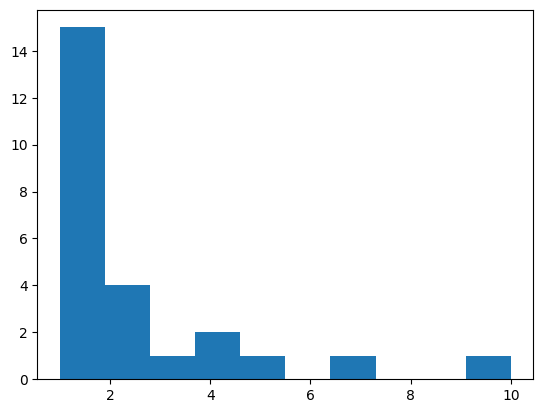

In [3]:
fig, ax = plt.subplots()

ax.hist(x = grid_res_df["grid"])

fig.show()

In [4]:
data = grid_res_df['grid']

# Convert to DataFrame and count occurrences
df = pd.Series(data).value_counts().reset_index()

# Rename columns
df.columns = ['number', 'count']

# Sort by number (optional)
df = df.sort_values(by='number').reset_index(drop=True)

# Reindex to include 1 through 22, filling missing counts with 0
# df = df.reindex(range(1, 23), fill_value=0).reset_index()

# Create full index from 1 to 22
full_range = pd.DataFrame({'number': range(1, 21)})

# Merge with existing counts, filling missing with 0
merged_df = full_range.merge(df, on='number', how='left').fillna(0)

# Convert count to integer (optional, for clean output)
merged_df['count'] = merged_df['count'].astype(int)

merged_df['prob'] = merged_df['count'] / sum(merged_df['count'])

merged_df

,number,count,prob
0,1,15,0.60
1,2,4,0.16
2,3,1,0.04
3,4,2,0.08
4,5,1,0.04
5,6,0,0.00
6,7,1,0.04
7,8,0,0.00
8,9,0,0.00
9,10,1,0.04


Fitted model: y = 2.0431 * exp(-1.2307 * x)


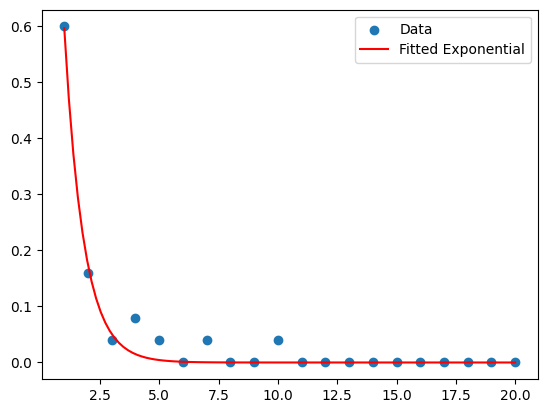

In [5]:
x = np.array(merged_df['number'])
y = np.array(merged_df['prob'])

# Exponential model
def exp_model(x, a, b):
    return a * np.exp(-b * x)

# Fit the curve
params, _ = curve_fit(exp_model, x, y, p0=(1, 1))

a, b = params
print(f"Fitted model: y = {a:.4f} * exp(-{b:.4f} * x)")

# Plot
x_fit = np.linspace(min(x), max(x), 100)
y_fit = exp_model(x_fit, a, b)

plt.scatter(x, y, label="Data")
plt.plot(x_fit, y_fit, color='red', label="Fitted Exponential")
plt.legend()
plt.show()

In [6]:
merged_df['exp'] = exp_model(merged_df['number'], a, b)
merged_df['exp'] = round(merged_df['exp'], 4)
merged_df['error'] = merged_df['exp'] - merged_df['prob']

merged_df

,number,count,prob,exp,error
0,1,15,0.60,0.5968,-0.0032
1,2,4,0.16,0.1743,0.0143
2,3,1,0.04,0.0509,0.0109
3,4,2,0.08,0.0149,-0.0651
4,5,1,0.04,0.0043,-0.0357
5,6,0,0.00,0.0013,0.0013
6,7,1,0.04,0.0004,-0.0396
7,8,0,0.00,0.0001,0.0001
8,9,0,0.00,0.0000,0.0000
9,10,1,0.04,0.0000,-0.0400


In [7]:
output_df = pd.DataFrame({
    'circuit': ['Monza' for i in range(len(merged_df['number']))],
    'grid_pos': merged_df['number'],
    'starting_prob': merged_df['exp']
})

output_df

,circuit,grid_pos,starting_prob
0,Monza,1,0.5968
1,Monza,2,0.1743
2,Monza,3,0.0509
3,Monza,4,0.0149
4,Monza,5,0.0043
5,Monza,6,0.0013
6,Monza,7,0.0004
7,Monza,8,0.0001
8,Monza,9,0.0000
9,Monza,10,0.0000


# Probability Rate
The next step is to determine a base probability dropoff rate. This is a little more complicated to do with limited data, so we are going to try and simplify it. The way we are going to view this base rate is that if nothing else were to happen over the course of a lap, how would the probability change. This means we can make a couple of assumptions:
- If you are in first, your probability of winning will increase. Logically this makes sense as there are less laps for the drivers below first to catch you and overtake
- If you have some probability to start with, as the race goes on, the probability declines for each lap that you don't make a position, as you have less laps to gain a position
- If you don't have any probability to start with, your gain will be 0

Another thing to note is that as the race goes on the amount of probability you gain or lose should also increase or decrease as there are less laps to overtake. Lets start by mathematically modelling how much probability we gain or lose. 

<positron-console-cell-10>:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


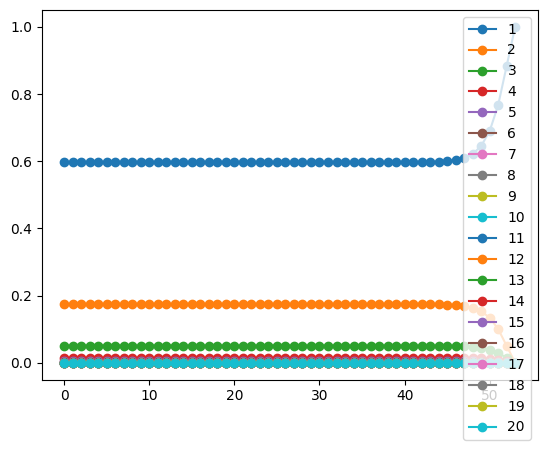

In [ ]:
def probability_change(prob, lap, total_laps, target = 0):
    distance = target - prob if target > prob else prob - target
    decline_rate = 2**(total_laps - lap)
    decline_rate = 1 / decline_rate
    prob_change = distance * decline_rate
    return prob - prob_change if target == 0 else prob + prob_change

fig, ax = plt.subplots()

for index, row in output_df.iterrows():
    total_laps = 53
    x = [0]
    y = [row['starting_prob']]

    for i in range(1, total_laps + 1):
        change = probability_change(y[i - 1], i, total_laps, 1 if row['grid_pos'] == 1 else 0)
        x.append(i)
        y.append(change)

    ax.plot(x, y, linestyle="-", marker="o", label = row['grid_pos'])

ax.legend()
fig.show()

Now that we have our base rates, to help with processing speeds, we are going to store this data in a dataframe to pull from later.

In [ ]:
circuit = 'monza'
laps = 53
data = []

for index, row in output_df.iterrows():
    x = [0]
    y = [row['starting_prob']]

    data.append({
        'circuit': circuit,
        'position': row['grid_pos'],
        'lap_number': 0,
        'state': row['starting_prob']
    })

    for i in range(1, total_laps + 1):
        change = probability_change(y[i - 1], i, total_laps, 1 if row['grid_pos'] == 1 else 0)
        x.append(i)
        y.append(change)
        data.append({
            'circuit': circuit,
            'position': row['grid_pos'],
            'lap_number': i,
            'state': change
        })

base_state_df = pd.DataFrame(data = data)

base_state_df

,circuit,position,lap_number,state
0,monza,1,0,0.5968
1,monza,1,1,0.5968
2,monza,1,2,0.5968
3,monza,1,3,0.5968
4,monza,1,4,0.5968
...,...,...,...,...
1075,monza,20,49,0.0000
1076,monza,20,50,0.0000
1077,monza,20,51,0.0000
1078,monza,20,52,0.0000


Lets take a look at a driver's race from Monza and how their win probability changed

<positron-console-cell-66>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Khalid.Talakshi/Documents/f1-podcast/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/Users/Khalid.Talakshi/Documents/f1-podcast/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1345: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return np.asarray(x, float)
<positron-console-cell-66>:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


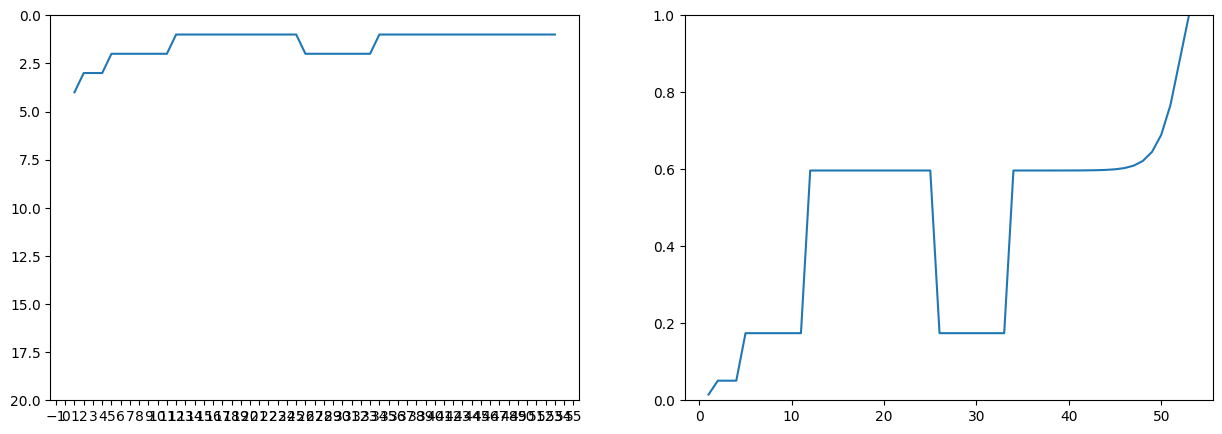

In [ ]:
from matplotlib.ticker import MultipleLocator

driver_lap_data = pd.read_csv('../data/driver-lap-data-monza.csv')
driver_id = 'max_verstappen'
race_year = 2022

sample_data = driver_lap_data[(driver_lap_data['year'] == race_year) & (driver_lap_data['driver_id'] == driver_id)]

sample_data.to_records()

prob_data = []

lap_col = 5
pos_col = 6

for row in sample_data.to_records():
    lap = row[lap_col]
    position = row[pos_col]

    new_prob = base_state_df[(base_state_df['lap_number'] == lap) & (base_state_df['position'] == position)]['state']

    prob_data.append(new_prob)

sample_data['prob'] = prob_data



fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(15, 5))

ax1.plot(sample_data["lap"], sample_data["position"])
ax1.yaxis.set_major_locator(MultipleLocator(1))
ax1.set_ylim(0, 20)
ax1.invert_yaxis()

ax2.plot(sample_data['lap'], sample_data['prob'])
ax2.set_ylim(0, 1)

fig.show()

# First Event: Gap Gain/Loss